# **TRABAJO INTEGRADOR PROCESAMIENTO DEL LENGUAJE NATURAL**

Grupo 1

# **CARGA DE DATOS**

In [1]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("dataset_balanceado_7000_por_clase.csv")

# Mostrar las primeras filas y las columnas disponibles
df.head(), df.columns

(                                           subject  \
 0                              Improvement Request   
 1  Encountering Periodic Performance Deterioration   
 2                                              NaN   
 3                                              NaN   
 4                                              NaN   
 
                                                 body  \
 0  Dear Customer Support Team,\n\nI hope this mes...   
 1                                Resolution Required   
 2  Dear Customer Support, I am seeking informatio...   
 3  Establish advanced security measures to safegu...   
 4  Kindly supply guidelines for safeguarding medi...   
 
                                               answer     type  \
 0  Thank you for the detailed inquiry concerning ...   Change   
 1  Examining periodic performance deterioration i...  Problem   
 2  Dear [name], thank you for your email. We offe...  Request   
 3  Implement advanced security measures to protec...   Chan

# **PRE-PROCESAMIENTO**

Antes de entrenar un modelo de clasificación, es fundamental limpiar y normalizar los mensajes. Para esto aplicamos un preprocesamiento básico de PLN que consiste en:

- Pasar a minúsculas: para unificar palabras (e.g. "Hello" y "hello").

- Eliminar signos de puntuación: como puntos o comas, que no aportan significado.

- Tokenizar: separar el texto en palabras individuales.

- Eliminar stopwords: palabras muy frecuentes como "the", "and", que no agregan valor semántico.

- Lematizar: reducir las palabras a su forma base (e.g., "running" → "run").

El resultado es un texto limpio, más uniforme y adecuado para representar numéricamente con técnicas como TF-IDF.

In [2]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('wordnet')

# Instanciar utilidades
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

# Función de limpieza
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Aplicar limpieza al campo body
df['body_clean'] = df['body'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ezevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ezevi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **VECTORIZACIÓN**

Luego de preprocesar los textos, transformamos cada mensaje en un vector numérico usando TF-IDF. Esta técnica asigna un valor a cada palabra basado en dos cosas: cuántas veces aparece en el mensaje (frecuencia) y cuán rara es en el resto del corpus. Así, las palabras más representativas de cada mensaje reciben mayor peso, mientras que las comunes se atenúan.

Esto nos permite convertir todos los textos en una matriz numérica que puede ser usada por algoritmos de clasificación. En nuestro caso, limitamos a las 5000 palabras más informativas para reducir el ruido y el tiempo de entrenamiento.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear vectorizador
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Aplicar a los textos ya limpios
X_tfidf = tfidf_vectorizer.fit_transform(df['body_clean'])

# Mostrar forma de la matriz
print("Matriz TF-IDF:", X_tfidf.shape)


Matriz TF-IDF: (28000, 5000)


# **ENTRENAMIENTO**

Utilizamos Regresión Logística como clasificador supervisado. Se entrenó con el 80% de los datos vectorizados con TF-IDF, y se evaluó con el 20% restante.

Resultados
- Accuracy general: 85%

F1-score por clase:

- Request: 0.99 (excelente)
- Incident: 0.83
- Change: 0.97
- Problem: 0.60 (más difícil de predecir)

La matriz de confusión muestra que el modelo se confunde más entre Problem e Incident, lo que puede indicar solapamiento semántico entre esas clases.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Vectorizar nuevamente
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['body'])

# Definir etiquetas
y = df['type']

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modelo de regresión logística
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


# **EVALUACION**

Este bloque realiza la evaluación del modelo clasificando los mensajes del conjunto de test. Primero, se generan las predicciones con el modelo entrenado y se comparan con las etiquetas reales mediante un classification_report, que muestra métricas como precisión, recall y F1-score para cada clase. Luego, se obtiene el listado de clases aprendidas por el modelo y se construye una matriz de confusión, que indica cuántos ejemplos fueron correctamente clasificados y cuántos se confundieron con otras clases. Finalmente, se muestra esa matriz en forma visual, lo que permite identificar fácilmente los aciertos (en la diagonal) y los errores de clasificación (fuera de la diagonal).



              precision    recall  f1-score   support

      Change       0.99      1.00      1.00      1417
    Incident       0.81      0.78      0.79      1391
     Problem       0.79      0.81      0.80      1393
     Request       1.00      0.99      1.00      1399

    accuracy                           0.90      5600
   macro avg       0.90      0.90      0.90      5600
weighted avg       0.90      0.90      0.90      5600



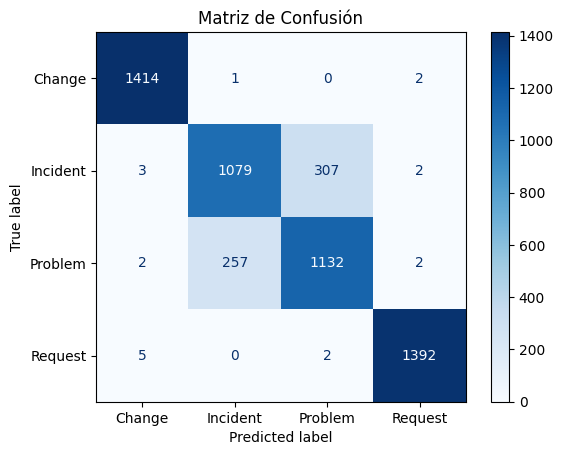

In [ ]:
# Predicción y evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Obtener nombres de clase directamente
target_names = model.classes_

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

# **Función para Clasificación de Mensajes Individuales**
Este bloque define una función llamada clasificar_mensaje que permite ingresar un mensaje de texto individual y obtener la clase que el modelo predice para ese mensaje. El proceso comienza con el preprocesamiento del texto, donde se limpia y normaliza usando la misma lógica aplicada durante el entrenamiento (por ejemplo, eliminación de stopwords, lematización, etc.). Luego, el texto ya limpio se transforma en un vector numérico utilizando el vectorizador TF-IDF entrenado previamente. Finalmente, ese vector se pasa al modelo de clasificación, que devuelve como resultado la clase predicha. Esta función es útil para probar manualmente ejemplos y ver cómo responde el modelo ante nuevos mensajes.

In [6]:
def clasificar_mensaje(texto):
    # Preprocesar el texto
    texto_preprocesado = preprocess_text(texto)

    # Vectorizar el texto con el mismo TF-IDF
    texto_vectorizado = tfidf_vectorizer.transform([texto_preprocesado])

    # Predecir clase
    prediccion = model.predict(texto_vectorizado)[0]

    return prediccion


# **INTERFAZ SIMPLE**

Para facilitar la prueba del modelo, creamos una interfaz simple donde se puede ingresar manualmente un mensaje de soporte y obtener la clase predicha en tiempo real. El texto ingresado pasa por el mismo proceso de preprocesamiento y vectorización utilizado durante el entrenamiento, asegurando coherencia con el modelo. Esto permite simular cómo funcionaría el sistema en una aplicación real de atención al cliente.

In [8]:
import ipywidgets as widgets
from IPython.display import display

# Crear widgets
input_box = widgets.Textarea(
    value='',
    placeholder='Escribí un mensaje de soporte...',
    description='Mensaje:',
    layout=widgets.Layout(width='100%', height='100px'),
    style={'description_width': 'initial'}
)

output_box = widgets.Output()

def on_submit(change):
    with output_box:
        output_box.clear_output()
        texto_ingresado = input_box.value
        if texto_ingresado.strip() == "":
            print("Por favor ingresá un mensaje.")
        else:
            pred = clasificar_mensaje(texto_ingresado)
            print(f"Clase predicha: {pred}")

# Botón de predicción
boton = widgets.Button(description="Clasificar mensaje")
boton.on_click(on_submit)

# Mostrar todo
display(input_box, boton, output_box)


Textarea(value='', description='Mensaje:', layout=Layout(height='100px', width='100%'), placeholder='Escribí u…

Button(description='Clasificar mensaje', style=ButtonStyle())

Output()